In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# collection of functions not organized into classes
def PrettyPrintBinary(state):
    outstr = ""
    if (type(state) == list and type(state[0]) == tuple):
        for i in range(len(state)):
            # if (not np.isclose(state[i][0] * np.conj(state[i][0]), 0.00000, rtol=1e-5)):
            outstr += f"{state[i][0]:.4f} |{state[i][1]}>"
            # outstr += (str)(state[i][0])
            # outstr += " |"
            # outstr += state[i][1]
            # outstr += "> "
            if (i < len(state) - 1):
                outstr += "+ "
        print(outstr)
    else:
        print("State is not valid")
def PrettyPrintInteger(state):
    if (type(state) == list):
        outstr = ""
        for i in range(len(state)):
            if (state[i] != 0):
                if (i != 0):
                    outstr += "+ "
                outstr += (str)(state[i])
                outstr += " |"
                outstr += str(i)
                outstr += "> "
        print(outstr)
    else:
        print("State passed to PrettyPrintInteger is not valid")

def VecToDirac(myVec):
    if ((type(myVec) == list and len(myVec) % 2 == 0)):
        newState = []
        binlen = int(np.log2(len(myVec)))
        for i in range(len(myVec)):
            if (myVec[i] != 0):
                bi = bin(i)[2:].zfill(binlen)
                newState.append((myVec[i], bi))
        return newState
    else:
        print("Error in VecToDirac")
        
def DiracToVec(state):
    if (not (type(state) == list and type(state[0]) == tuple)):
        print("Error in DiracToVec")
    else:
        newVec = []
        for i in range(2**len(state[0][1])):
            newVec.append(0)
        for s in state:
            newVec[int(s[1], 2)] = s[0]
        return newVec
def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def GetStateFromFile(file, dirac):
    a = open(file).read()
    a = a.split("\n")
    output = []
    for i in a:
        x = i.split(' ')
        output.append(float(x[0]) + float(x[1]) * 1.j)
    if (dirac):
        return VecToDirac(output)
    return output
    
def TensorMe(listOfMatrices):
    current = listOfMatrices[0]
    for i in range(len(listOfMatrices) - 1):
        current = np.kron(current, listOfMatrices[i+1])
    return current
    

In [251]:
# Simulator S
class S:
    def H(wire, inputState):
        newState = []
        for s in inputState:
            if (s[1][wire] == '0'):
                bi = list(s[1])
                bi[wire] = '0'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
                bi[wire] = '1'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
            if (s[1][wire] == '1'):
                bi = list(s[1])
                bi[wire] = '0'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
                bi[wire] = '1'
                newState.append((s[0] * -np.sqrt(1/2), "".join(bi)))
        return newState

    def Phase(wire, theta, inputState):
        newState = []
        for s in inputState:
            if (s[1][wire] == '0'):
                newState.append(s)
            else:
                newState.append((s[0] * np.exp(1.j * theta), s[1]))
        return newState

    def CNOT(controlwire, notwire, inputState):
        newState = []
        for s in inputState:
            if (s[1][controlwire] == '0'):
                newState.append(s)
            else:
                bi = list(s[1])
                bi[notwire] = str((int(bi[notwire]) + 1) % 2)
                # if (bi[notwire] == '0'):
                #     print("here")
                #     bi[notwire] == '1'
                # else:
                #     bi[notwire] == '0'
                string = "".join(bi)                
                newState.append((s[0], string))
        return newState
    
    def AddDuplicates(inputState):
        bidict = {}
        for s in inputState:
            if (s[1] in bidict):
                bidict[s[1]] += s[0]
            else:
                bidict[s[1]] = s[0]
        
        outstate = []
        for i in bidict.keys():
            if (not np.isclose(bidict[i], 0)):
                outstate.append((bidict[i], i))
        return outstate
    
    def measure(state, size = 1):
        possibleStates = []
        probabilities = []
        for s in state:
            possibleStates.append(s[1])
            probabilities.append(s[0] * np.conjugate(s[0]))
        rng = np.random.default_rng()
        return rng.choice(possibleStates, size=size, p=np.real(probabilities))

    def ReadAndProcessString(input_lines, test=False, measures=1):
        numberOfWires, inputGates = ReadInputString(input_lines)
        bin = ''
        for i in range(numberOfWires):
            bin += '0'
        currentState = [(1, bin)]
        for g in inputGates:
            
            if (g[0] == 'INITSTATE'):
                if (g[1] == 'BASIS'):
                    currentState[0] = (1, g[2][1:-1])
                    if(test):
                        print("BASIS")
                if (g[1] == 'FILE'):
                    currentState = GetStateFromFile(g[2], True)
            if (g[0] == 'H'):
                if (test):
                    print("H " + g[1])
                currentState = S.H(int(g[1]), currentState)
            if (g[0] == 'P'):
                if (test):
                    print("P " + g[2])
                currentState = S.Phase(int(g[1]), float(g[2]), currentState)
            if (g[0] == 'CNOT'):
                if (test):
                    print("CNOT " + g[1] + " " + g[2])
                currentState = S.CNOT(int(g[1]), int(g[2]), currentState)
            currentState = S.AddDuplicates(currentState)
            if (test):
                PrettyPrintBinary(currentState)
            if (g[0] == 'MEASURE'):
                return S.measure(currentState, measures)
        return currentState

In [25]:
# Class for simulator M-a
class MA:
    H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    
    def Hadamard(i, k):
        """creates a hadamard array
        i: target wire
        k: number of wires"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(MA.H)
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr)
    def Phase(i, k, theta):
        """creates a phase matrix
        i: target wire
        k: number of wires
        theta: the phase to rotate by"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(np.array([[1, 0], [0, np.exp(1.j * theta)]]))
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr)
    def CNOT(controlwire, otherwire, totalwires):
        """creates a matrix for a CNOT gate
        controlwire: the control wire
        otherwire: the target wire (must be adjacent to control)
        totalwires: yeah"""
        if not((controlwire - 1 == otherwire) or (controlwire + 1 == otherwire)):
            raise(ValueError("Controlwire and otherwire must be adjacent"))
        arr = []
        hasntRun = True
        j = 0
        while j < totalwires:
            if (j == controlwire or j == otherwire) and hasntRun:
                t = np.eye(4)
                if (controlwire < otherwire):
                    t[:, [2, 3]] = t[:, [3, 2]] 
                else:
                    t[:, [0, 1]] = t[:, [1, 0]]
                arr.append(t)
                j = j + 1
                hasntRun = False
            elif j < controlwire:
                arr.append(np.eye(2))
            elif j > otherwire:
                arr.append(np.eye(2))
            j = j + 1
        return TensorMe(arr)
    
    def CreateCircutMatrix(input_lines):
        numberOfWires, inputGates = ReadInputString(input_lines)
        currentState = list(np.zeros(numberOfWires))
        ListOmatrices = []
        for g in inputGates:
            if (g[0] == 'H'):
                ListOmatrices.append(MA.Hadamard(int(g[1]), numberOfWires))
            if (g[0] == 'P'):
                ListOmatrices.append(MA.Phase(int(g[1]), numberOfWires, float(g[2])))
            if (g[0] == 'CNOT'):
                ListOmatrices.append(MA.CNOT(int(g[1]), int(g[2]), numberOfWires))
            
        TheMatrix = np.eye(2**numberOfWires)
        ListOmatrices = ListOmatrices[::-1]
        for m in ListOmatrices:
            TheMatrix = TheMatrix @ m
        return TheMatrix
        
            

In [277]:
# Class for simulator M-b
class MB:
    H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    
    def Hadamard(i, k, state):
        """creates a hadamard array
        i: target wire
        k: number of wires"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(MA.H)
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr) @ state
    def Phase(i, k, theta, state):
        """creates a phase matrix
        i: target wire
        k: number of wires
        theta: the phase to rotate by"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(np.array([[1, 0], [0, np.exp(1.j * theta)]]))
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr) @ state
    def CNOT(controlwire, otherwire, totalwires, state):
        """creates a matrix for a CNOT gate
        controlwire: the control wire
        otherwire: the target wire (must be adjacent to control)
        totalwires: yeah"""
        if not((controlwire - 1 == otherwire) or (controlwire + 1 == otherwire)):
            raise(ValueError("Controlwire and otherwire must be adjacent"))
        arr = []
        hasntRun = True
        j = 0
        while j < totalwires:
            if (j == controlwire or j == otherwire) and hasntRun:
                t = np.eye(4)
                if (controlwire < otherwire):
                    t[:, [2, 3]] = t[:, [3, 2]] 
                else:
                    t[:, [0, 1]] = t[:, [1, 0]]
                arr.append(t)
                j = j + 1
                hasntRun = False
            elif j < controlwire:
                arr.append(np.eye(2))
            elif j > otherwire:
                arr.append(np.eye(2))
            j = j + 1
        return TensorMe(arr) @ state
    
    def ReadAndRunCircuit(input_lines, startstate):
        numberOfWires, inputGates = ReadInputString(input_lines)
        currentState = startstate
        ListOmatrices = []
        for g in inputGates:
            if (g[0] == 'H'):
                currentState = MB.Hadamard(int(g[1]), numberOfWires, currentState)
            if (g[0] == 'P'):
                currentState = MB.Phase(int(g[1]), numberOfWires, float(g[2]), currentState)
            if (g[0] == 'CNOT'):
                currentState = MB.CNOT(int(g[1]), int(g[2]), numberOfWires, currentState)
            if (g[0] == 'MEASURE'):
                print(currentState)
                return S.measure(VecToDirac(list(currentState)))
        return currentState

In [271]:
# turn each nonatomic gate into a string of atomic gates
def NOT(wire):
    return f"H {wire}\nP {wire} {np.pi}\nH {wire}\n"
def Rz(wire, phase):
    return f"{NOT(wire)}P {wire} {-phase/2}\n{NOT(wire)}P {wire} {phase/2}\n"
def CRz(controlwire, targetwire, phase):
    return f"CNOT {controlwire} {targetwire}\nP {targetwire} {phase/2}\nCNOT {controlwire} {targetwire}\nP {targetwire} {-phase/2}\n"
def CPhase(controlwire, targetwire, phase):
    return f"P {targetwire} {phase/2}\nCNOT {controlwire} {targetwire}\nP {targetwire} {-phase/2}\nCNOT {controlwire} {targetwire}\nP {controlwire} {phase/2}\n"
def Swap(firstwire, secondwire):
    return f"CNOT {firstwire} {secondwire}\nCNOT {secondwire} {firstwire}\nCNOT {firstwire} {secondwire}\n"

In [278]:
# Precompiler code
def is_number(s): # stolen from stackoverflow: https://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-represents-a-number-float-or-int
    try:
        float(s)
        return True
    except ValueError:
        return False

def Precompile(input):
    input = input.split("\n")
    output = """"""
    for i in input:
        a = i.split(' ')
        if (a[0] == "H" or a[0] == "CNOT" or a[0] == "P" or is_number(a[0]) or a[0] == "MEASURE" or a[0] == "INITSTATE"):
            output += i
            output += "\n"
        if (a[0] == "NOT"):
            output += NOT(int(a[1]))
        if (a[0] == "RZ"):
            output += Rz(int(a[1]), float(a[2]))
        if (a[0] == "CRZ"):
            output += CRz(int(a[1]), int(a[2]), float(a[3]))
        if (a[0] == "CPHASE"):
            output += CPhase(int(a[1]), int(a[2]), float(a[3]))
        if (a[0] == "SWAP"):
            output += Swap(a[1], a[2])
    return output
        

In [27]:
#early tests
myState=[
  (-np.sqrt(0.125), '11' ),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01') ,
  (-np.sqrt(0.125), '11' )
]
myState2=[
   (np.sqrt(0.1)*1.j, '101'),
   (np.sqrt(0.5), '000') ,
   (-np.sqrt(0.4), '010' )]
myEquivilentState2 = [np.sqrt(0.5), 0, -np.sqrt(0.4), 0, 0, np.sqrt(0.1)*1.j, 0, 0]
PrettyPrintBinary(myState2)
PrettyPrintInteger(myEquivilentState2)
PrettyPrintBinary(VecToDirac(myEquivilentState2))
PrettyPrintInteger(DiracToVec(myState2))
PrettyPrintBinary(VecToDirac(DiracToVec(myState2)))

0.31622776601683794j |101> + 0.7071067811865476 |000> + -0.6324555320336759 |010> 
0.7071067811865476 |0> + -0.6324555320336759 |2> + 0.31622776601683794j |5> 
0.7071067811865476 |000> + -0.6324555320336759 |010> + 0.31622776601683794j |101> 
0.7071067811865476 |0> + -0.6324555320336759 |2> + 0.31622776601683794j |5> 
0.7071067811865476 |000> + -0.6324555320336759 |010> + 0.31622776601683794j |101> 


In [284]:
# second set of early tests
sampleInput = '''
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
'''
sampleInput2 = open('example.circuit').read()
input3 = open('rand.circuit').read()
numberOfWires,myInput=ReadInputString(sampleInput)
PrettyPrintBinary(S.ReadAndProcessString(sampleInput))
PrettyPrintBinary(S.ReadAndProcessString(sampleInput2))
PrettyPrintBinary(S.ReadAndProcessString(input3))

0.9777+0.1478j |000>+ 0.0223-0.1478j |101>
0.5000 |0000>+ 0.5000 |0011>+ 0.4502+0.2175j |1100>+ 0.4502+0.2175j |1111>
0.1457+0.1135j |00000>+ -0.0002+0.0801j |00010>+ 0.0015-0.0365j |10000>+ -0.0821+0.0155j |10010>+ 0.0431-0.1218j |00001>+ 0.0504-0.0073j |00011>+ -0.0127+0.0055j |10001>+ 0.0160+0.0226j |10011>+ 0.0723-0.0226j |00100>+ 0.0539+0.0090j |00110>+ -0.1717+0.3669j |10100>+ -0.1469-0.0436j |10110>+ -0.0344-0.0422j |00101>+ 0.0018-0.0268j |00111>+ 0.2775+0.0423j |10101>+ 0.0074+0.1079j |10111>+ 0.1346-0.1256j |01000>+ 0.0107+0.0709j |01010>+ -0.4427-0.0892j |11000>+ -0.0548-0.2147j |11010>+ -0.1041-0.0676j |01001>+ 0.0315-0.0354j |01011>+ 0.0343+0.3180j |11001>+ -0.1210+0.0654j |11011>+ 0.0079+0.2979j |01100>+ -0.1131-0.0228j |01110>+ -0.1814-0.0780j |11100>+ -0.0578+0.0101j |11110>+ 0.1961-0.0584j |01101>+ 0.0257+0.0756j |01111>+ -0.0059+0.1270j |11101>+ -0.0118+0.0200j |11111>


In [282]:
# more basic testing
testState1 = list(np.zeros((16)))
testState1[12] = 1.0
ar = MA.CNOT(0, 1, 4)
PrettyPrintBinary(VecToDirac(testState1))
PrettyPrintBinary(VecToDirac(list(testState1@ar)))

1.0000 |1100>
1.0000 |1000>


In [283]:
# testing strings
testCircuit = '''3
H 1
CNOT 1 2
P 0 0.45'''
# print(MA.CreateCircutMatrix(testCircuit))
startstate = [0, 0, 0, 0, 1, 0, 0, 0]
PrettyPrintBinary(VecToDirac(startstate))
c = MA.CreateCircutMatrix(testCircuit)
d = MB.ReadAndRunCircuit(testCircuit, startstate)
PrettyPrintBinary(VecToDirac(list(d)))
print(S.measure(VecToDirac(list(d))))

1.0000 |100>
0.6367+0.3076j |100>+ 0.6367+0.3076j |111>
['100']


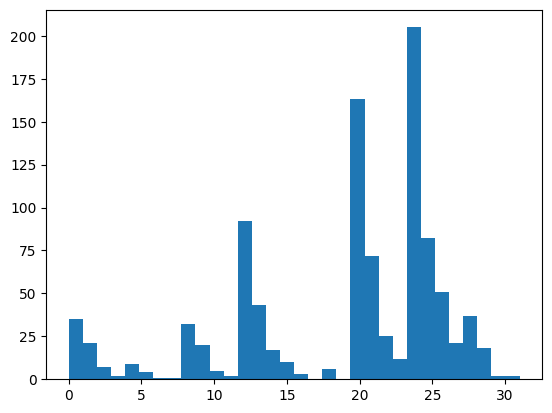

In [285]:
# Running simulator S 1000 times on measure.circuit
# x axis is in decimal notation
measureInput = open('measure.circuit').read()
count = []
for i in range(32):
    count.append(0)
temp = S.ReadAndProcessString(measureInput, measures=1000)
measured = [int(x, 2) for x in temp]
# for i in range(1000):
#     # count[int(S.ReadAndProcessString(measureInput), 2)] += 1
#     measured.append(int(S.ReadAndProcessString(measureInput), 2))
#     # print(int(S.ReadAndProcessString(measureInput), 2))
_ = plt.hist(measured, bins=32)

In [286]:
# testing advanced circuit descriptions
inputTest = open('input.circuit').read()
PrettyPrintBinary(S.ReadAndProcessString(inputTest))

secondInputTest = '''
3
INITSTATE BASIS |001>
H 2'''

PrettyPrintBinary(S.ReadAndProcessString(secondInputTest))

0.1541-0.0390j |00000>+ -0.0213+0.0877j |00010>+ -0.1480+0.0875j |10000>+ 0.1169+0.0138j |10010>+ 0.0490-0.0300j |00001>+ -0.1116-0.2333j |00011>+ -0.0633+0.2566j |10001>+ -0.0267-0.0041j |10011>+ -0.0339-0.0097j |00100>+ -0.1959+0.0099j |00110>+ 0.2192-0.2130j |10100>+ -0.1479-0.1048j |10110>+ -0.0167-0.1303j |00101>+ -0.0980+0.0135j |00111>+ -0.0489-0.1164j |10101>+ 0.2232+0.0508j |10111>+ -0.1808+0.0144j |01000>+ 0.0010-0.0035j |01010>+ -0.1396-0.2372j |11000>+ -0.2632-0.0656j |11010>+ 0.0538-0.0686j |01001>+ -0.0215+0.0174j |01011>+ 0.1848-0.0051j |11001>+ 0.1752-0.0201j |11011>+ -0.0072+0.1596j |01100>+ -0.0379+0.0059j |01110>+ 0.1122+0.0012j |11100>+ -0.2083+0.0770j |11110>+ -0.2231+0.0746j |01101>+ 0.0739-0.0507j |01111>+ 0.0242-0.1245j |11101>+ 0.0548+0.3061j |11111>
0.7071 |000>+ -0.7071 |001>


In [287]:
# implementation of NOT gate
NOTGate = '''
1
INITSTATE BASIS |0>
H 0
P 0 3.14159265
H 0'''
PrettyPrintBinary(S.ReadAndProcessString(NOTGate))

1.0000-0.0000j |1>


In [288]:
# Implementation of Rz(0.8)
RzGate = '''
1
INITSTATE BASIS |0>
H 0
P 0 3.14159265
H 0
P 0 -0.4
H 0
P 0 3.14159265
H 0
P 0 0.4'''
PrettyPrintBinary(S.ReadAndProcessString(RzGate))

0.9211-0.3894j |0>


In [289]:
# CRz gate with 0th wire as control and 1th wire as target
CRzGate = '''
2
INITSTATE BASIS |11>
CNOT 0 1
P 1 -0.4
CNOT 0 1
P 1 0.4'''
PrettyPrintBinary(S.ReadAndProcessString(CRzGate))

0.9211+0.3894j |11>


In [261]:
# working Controlled phase gate that rotates by 0.8
CPGate = '''
2
INITSTATE BASIS |00>
P 1 0.4
CNOT 0 1
P 1 -0.4
CNOT 0 1
P 0 0.4
'''
PrettyPrintBinary(S.ReadAndProcessString(CPGate))

1.0000 |00>


In [269]:
# Swap gate
SwapGate = '''
3
INITSTATE BASIS |010>
CNOT 0 2
CNOT 2 0
CNOT 0 2
'''
PrettyPrintBinary(S.ReadAndProcessString(SwapGate))

1.0000 |010>


In [290]:
# Testing the precompile step
testPrecompile = '''
9
H 0
CPHASE 0 5 0.3
P 1 0.3
CNOT 4 7
SWAP 2 8'''
print(Precompile(testPrecompile))

9
H 0
P 5 0.15
CNOT 0 5
P 5 -0.15
CNOT 0 5
P 0 0.15
P 1 0.3
CNOT 4 7
CNOT 2 8
CNOT 8 2
CNOT 2 8

